# Определение стоимости автомобилей


# Оглавление

- [1. Введение](#1.)
- [1.1. Формулировка задачи](#1.1)
- [1.2. Описание данных](#1.2)
- [2. Подготовка данных](#2)
- [2.1. Первое знакомство с данными](2.1)
- [2.2. Обработка данных](#2.2)
- [3. Машинное обучение](#3)
- [3.1. LightGBM](#3.1)
- [3.2. ElasticNetCV](#3.2)
- [4. Выводы](#4)

In [29]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from  sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
import optuna
import warnings

# 1. Введение <a id="1."></a>

## 1.1. Формулировка задачи
<a id="1.1"></a>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.
Заказчику важны:
•	качество предсказания;
•	скорость предсказания;
•	время обучения.

•	Для оценки качества моделей необходимо использовать метрику RMSE.
•	Значение RMSE должно быть меньше 2500.
•	Обучить несколько моделей, в т.ч. LightGBM.
•	Необходимо контролировать время обучения и предсказания модели
•	Поскольку модель градиентного бустинга может обучаться долго, допускается использовать и менть у неё только два-три параметра.

Прим:
•	Если перестанет работать Jupyter Notebook, допускается удалять лишние переменные оператором del:


## 1.2. Описание данных
<a id="1.2"></a>

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)


# 2. Подготовка данных <a id="2"></a>

## 2.1. Первое знакомство с данными <a id="2.1"></a>

In [2]:
path1 = 'autos.csv'
path2 = 'datasets/autos.csv'

if os.path.exists(path1):
    df = pd.read_csv(path1)
elif os.path.exists(path2):
    df = pd.read_csv(path1)
else: print('Путь к файлу не найден')

In [3]:
print(df.info())
display(df.head(3))
initioal_length = len(df)
print('исходное количество записей в датасете:',initioal_length)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


исходное количество записей в датасете: 354369


In [4]:
# проврим наличие дубликатов
print('всего явных дубликатов', df.duplicated().sum())

всего явных дубликатов 4


Посмотрим на гистограммы

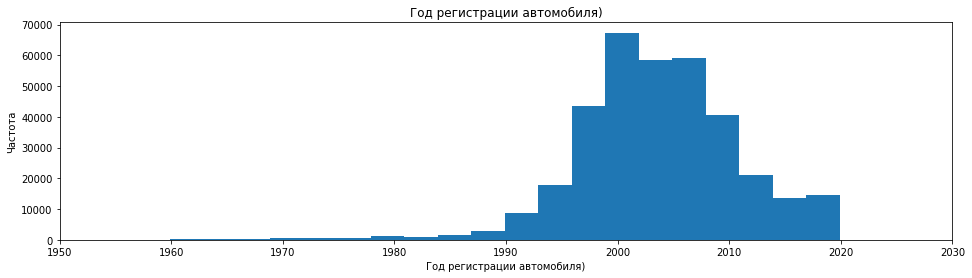

In [5]:
ax = df['RegistrationYear'].plot(kind='hist', bins=3000, figsize = (16,4), title = 'Год регистрации автомобиля)')
plt.xlim(1950,2030)
ax.set(xlabel= 'Год регистрации автомобиля)', ylabel = 'Частота')
plt.show()

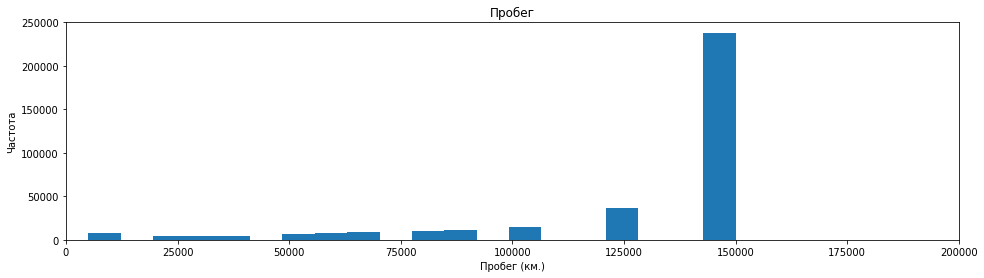

In [6]:
ax = df['Kilometer'].plot(kind='hist', bins=20, figsize = (16,4), title = 'Пробег')
plt.xlim(0,200000)
ax.set(xlabel= 'Пробег (км.)', ylabel = 'Частота')
plt.show()

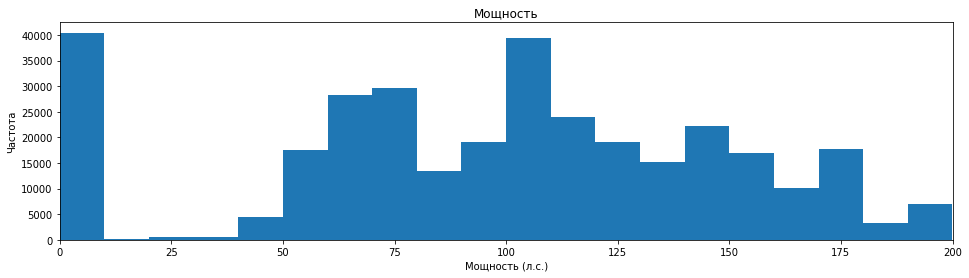

In [7]:
ax = df['Power'].plot(kind='hist', bins=2000, figsize = (16,4), title =  'Мощность')
plt.xlim(0,200)
ax.set(xlabel= 'Мощность (л.с.)', ylabel = 'Частота')
plt.show()

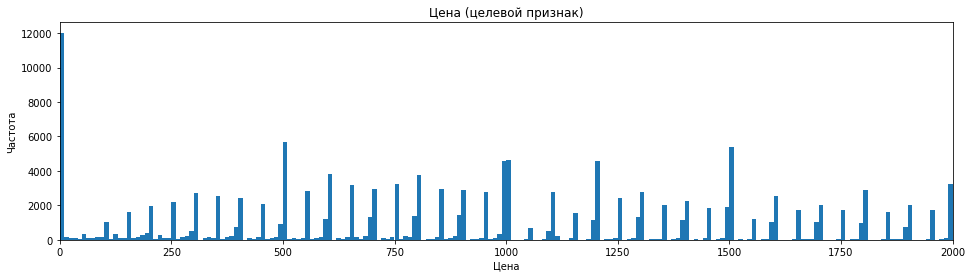

In [8]:
ax = df['Price'].plot(kind='hist', bins=2000, figsize = (16,4), title =  'Цена (целевой признак)')
plt.xlim(0,2000)
ax.set(xlabel= 'Цена', ylabel = 'Частота')
plt.show()

Предварительный вывод по гистограммам: Похоже, что еть записи с нулевой мощностью и нулевой ценой. Необходимо посмотреть внимательнее на них. По пробугу и году регистрации вроде все ок.

**Сравним даты**

In [9]:
# преобразуем DateCrawled в формат даты
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
# вытащим из него значение года
df['DateCrawled_year'] = df['DateCrawled'].dt.year.astype(int)
# и месяца
df['DateCrawled_month'] = df['DateCrawled'].dt.month.astype(int)
# проверим как получилось
display(df[['DateCrawled', 'DateCrawled_year', 'DateCrawled_month']].head())
print('получилось норм.')

,DateCrawled,DateCrawled_year,DateCrawled_month
0,2016-03-24 11:52:17,2016,3
1,2016-03-24 10:58:45,2016,3
2,2016-03-14 12:52:21,2016,3
3,2016-03-17 16:54:04,2016,3
4,2016-03-31 17:25:20,2016,3


получилось норм.


In [10]:
df_wrong_date = df[(df['DateCrawled_year'] < df['RegistrationYear']) | ((df['DateCrawled_year'] == df['RegistrationYear']) & (df['DateCrawled_month'] < df['RegistrationMonth']) )]
print('Количетво записей, где скачивание анкеты из базы раньше, чем год регистрации автомобиля =', len(df_wrong_date))

Количетво записей, где скачивание анкеты из базы раньше, чем год регистрации автомобиля = 19759


Посмотрим на эти записи

In [11]:
df_wrong_date.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DateCrawled_year,DateCrawled_month
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33,2016,3
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46,2016,3
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07,2016,3
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50,2016,3
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44,2016,3


Похоже, что-то не так именно с годом регистрации, а не с датой скачивания с базы. Например Opel Meriva, судя по данным из википедии, выпускался до 2017, а в датасете указан 2018 год регистрации. Может конечно быть и так, что машина год в салоне стояла или выпущена в декабре 2017, а продана в январе 2018, но за неимением информации на сей счет и в целях гарантирования валидности данных исключим эти записи из датасета. (на общем фоне уменьшение не будет критичным)   

**Посчитаем нулевые значения и посмотрим на данные с ними**

In [12]:
print('Количество записей с нулевым значением мощности составляет:', df.loc[df['Power']==0,'Power'].count())
print('пример таких записей')
display(df[df['Power']==0].head())

print('Количество записей с нулевым значением цены составляет:', df.loc[df['Price']==0,'Price'].count())
print('пример таких записей')
display(df[df['Price']==0].head())

Количество записей с нулевым значением мощности составляет: 40225
пример таких записей


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DateCrawled_year,DateCrawled_month
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016,3
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47,2016,3
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43,2016,3
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02,2016,3
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34,2016,3


Количество записей с нулевым значением цены составляет: 10772
пример таких записей


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DateCrawled_year,DateCrawled_month
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58,2016,3
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34,2016,3
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05,2016,3
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22,2016,3
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10,2016,3


Посмотрим на категориальные признаки.

In [13]:
print('Уникальные значения параметра Vehicletype:', df['VehicleType'].unique().tolist())
print('Уникальные значения параметра Gearbox:', df['Gearbox'].unique().tolist())
print('Уникальные значения параметра FuelType:', df['FuelType'].unique().tolist())
print('Уникальные значения параметра Brand:', df['Brand'].unique().tolist())
print('Уникальные значения параметра NotRepaired:', df['NotRepaired'].unique().tolist())

Уникальные значения параметра Vehicletype: [nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other']
Уникальные значения параметра Gearbox: ['manual', 'auto', nan]
Уникальные значения параметра FuelType: ['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric']
Уникальные значения параметра Brand: ['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai', 'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia', 'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo', 'porsche', 'rover', 'land_rover', 'lada']
Уникальные значения параметра NotRepaired: [nan, 'yes', 'no']


Выводы:

1. В типе топлива нет "дизель", но есть 'petrol' и 'gasoline', что переводится как "бензин" в зависимости от страны (Англия или США). Вряд ли датасет был собран из баз разных стран, а дизель, все же, везде переводится как "diesel". В общем много вопросов к датасету, но пожалуй не будем с этим ничего делать.
2. Скрытых дубликатов в марках автомобилей нет (но зато есть lada =), и судя по марке trabant - это все же Европейская база.

### Подытог
Наблюдения:

1. В следующих столбцах данных присутствуют пропуски:
    1. VehicleType
    2. Gearbox
    3. Model
    4. FuelType
    5. NotRepaired
   При этом, это пропуски в категориальных параметрах
2. Столбцы с датами (проведем следующую декомпозицию):
    1. Ненужные столбцы: DateCrawled (дата скачивания анкеты из базы), DateCreated (дата создания анкеты), LastSeen (дата последней активности пользователя), RegistrationMonth (месяц регистрации автомобиля) - вряд ли они влияют на цену автомобиля, поэтому просто удалим их.
    2. столбец RegistrationYear - оставим типа int, т.к. в общем случае чем старше, тем дешевле.
3. найдено 4 полных дубликата.
4. Параметры названы с заглавной буквы
5. Присутствуют записи с нулевым значением цены и мощности
6. присутствует некорая неясность с категориальными переменными
7. Присутствуют ошибки в параметре "Год регистрации"
8. Присутствуют категориальные параметры:
    1. VehicleType
    2. Gearbox
    3. Model
    4. FuelType
    5. Brand
    6. NotRepaired
    7. PostalCode

Выводы:
1. Заполнить пропуски значением "was_nan" (поскуольку данные категориальные мы не можем заполнить медианным значением, а самым частотным - воможно не "честныый" подход, т.к. возможно, сами пропуски имеют значимость. в идеале это надо протестировать, но в рамках учебного задания опустим это действие)
2. Столбцы с датами:
    1. DateCrawled, DateCreated, LastSeen
    2. Разбить на сезоны столбец RegistrationMonth и после удалить
3. Удалить дубликаты строк
4. Привести названия параметров к нижнему регистру
5. Записи с нулевым значением:
    - с нулевым значением цены - удалим, т.к. вероятно это ошибка, и если мы сервис спрогнозирует клиенту цену "0 руб 0 коп." вряд ли клиент посчитает этот сервис хорошим..
    - с нулевым значением мощности.. так же удалим, т.к. для одинаковых моделей и годов выпуска могут быть различные двигатели и это может прям существенно влиять на цену (более мощный двигатель может добавить до 60% от стоимости). А поскольку никаких других зацепок как получить мощность у нас нет, наиболле лучшим для прогноза будет просто "грохнуть" эти записи (к тому же тема данного модуля - знакомство с градиентным бустингом, надо помнить..=)
6. Категориальне переменные не меняем
7. Удалить записи с невалидным годом регистрации
8. Для XGBost Создать датасет с OHE-обработкой, и подготовить список категориальных признаков для LightGBM и CatBoost

### 2.2.1. удаление записей с невалидным годом регистрации

Сперва посмотрим на размер датфареймов

In [14]:
print('размер исходного датафрейма', df.shape)
print('длина датафрейма с невалидными датами регистрации', len(df_wrong_date))
print('длина исходногг датафрейма - невалидные значения ', len(df) - len(df_wrong_date))

размер исходного датафрейма (354369, 18)
длина датафрейма с невалидными датами регистрации 19759
длина исходногг датафрейма - невалидные значения  334610


In [15]:
df = df.drop(df_wrong_date.index, axis=0)
print('после удаления записей с невалидными датами регистрации размер датафрейма стал: ',df.shape, '\nразмер сходится удалили корректно')

после удаления записей с невалидными датами регистрации размер датафрейма стал:  (334610, 18) 
размер сходится удалили корректно


### 2.2.2. Заполнение пропусков

In [16]:
to_fill_in_columns_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

for col in to_fill_in_columns_list:
    df[col].fillna(value = 'was_nan', inplace=True)
# проверим как заполнилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334610 entries, 0 to 354368
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        334610 non-null  datetime64[ns]
 1   Price              334610 non-null  int64         
 2   VehicleType        334610 non-null  object        
 3   RegistrationYear   334610 non-null  int64         
 4   Gearbox            334610 non-null  object        
 5   Power              334610 non-null  int64         
 6   Model              334610 non-null  object        
 7   Kilometer          334610 non-null  int64         
 8   RegistrationMonth  334610 non-null  int64         
 9   FuelType           334610 non-null  object        
 10  Brand              334610 non-null  object        
 11  NotRepaired        334610 non-null  object        
 12  DateCreated        334610 non-null  object        
 13  NumberOfPictures   334610 non-null  int64   

Пропуски заполнились

### 2.2.3. Удаление столбцов

In [17]:
to_drop_column_list = ['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth']

df.drop(columns=to_drop_column_list, axis=1, inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334610 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              334610 non-null  int64 
 1   VehicleType        334610 non-null  object
 2   RegistrationYear   334610 non-null  int64 
 3   Gearbox            334610 non-null  object
 4   Power              334610 non-null  int64 
 5   Model              334610 non-null  object
 6   Kilometer          334610 non-null  int64 
 7   FuelType           334610 non-null  object
 8   Brand              334610 non-null  object
 9   NotRepaired        334610 non-null  object
 10  NumberOfPictures   334610 non-null  int64 
 11  PostalCode         334610 non-null  int64 
 12  DateCrawled_year   334610 non-null  int32 
 13  DateCrawled_month  334610 non-null  int32 
dtypes: int32(2), int64(6), object(6)
memory usage: 35.7+ MB
None


### 2.2.4. Удаление дубликатов

In [18]:
df.drop_duplicates(inplace=True)

### 2.2.5. Переименование столбцов

In [19]:
df.columns = df.columns.str.lower()
print('новые названия столбцов:',df.columns)

новые названия столбцов: Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'notrepaired', 'numberofpictures',
       'postalcode', 'datecrawled_year', 'datecrawled_month'],
      dtype='object')


### 2.2.6. Удаление записей с нулевыми значениямми

In [20]:
df = df.dropna(subset=['power', 'price']).reset_index(drop=True)
# проверка
print('кол-во записей с нулевым значением мощности', df[df['power'].isna()]['power'].count())
print('кол-во записей с нулевым значением цены', df[df['price'].isna()]['price'].count())

кол-во записей с нулевым значением мощности 0
кол-во записей с нулевым значением цены 0


In [21]:
len_after_drop = len(df)
decreased = (initioal_length-len_after_drop)/initioal_length
print('после удаления заисей датасет уменьшился на {:.2%}'.format(decreased))

после удаления заисей датасет уменьшился на 11.37%


### 2.2.7. Обработка категориальных параметров

In [22]:
print('размер текущего датафрейма:', df.shape)
cat_params_list = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired', 'postalcode']

numeric_params_list = list(set(df.columns) - set(cat_params_list))
df_ohe = pd.get_dummies(df[cat_params_list], drop_first=True)

print('размер датафрейма с только OHE параметрами:', df_ohe.shape)
print('размер датафрейма с колличественными парметрами:', df[numeric_params_list].shape)

размер текущего датафрейма: (314084, 14)
размер датафрейма с только OHE параметрами: (314084, 309)
размер датафрейма с колличественными парметрами: (314084, 7)


In [23]:
df_ohe_full = pd.concat([df[numeric_params_list], df_ohe], axis=1)
print('размер датафрейма с колличественными  и OHE парметрами:', df_ohe_full.shape)

размер датафрейма с колличественными  и OHE парметрами: (314084, 316)


# 3. Машинное обучение <a id="3"></a>

In [24]:
target = df['price']
features = df.drop(columns=['price'], axis=1)
print('размер целевого признака', target.shape)
print('размер параметров', features.shape)

размер целевого признака (314084,)
размер параметров (314084, 13)


In [25]:
features_cat = features.copy()
for feature in cat_params_list:
    features_cat[feature] = features_cat[feature].astype('category')
features_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314084 entries, 0 to 314083
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicletype        314084 non-null  category
 1   registrationyear   314084 non-null  int64   
 2   gearbox            314084 non-null  category
 3   power              314084 non-null  int64   
 4   model              314084 non-null  category
 5   kilometer          314084 non-null  int64   
 6   fueltype           314084 non-null  category
 7   brand              314084 non-null  category
 8   notrepaired        314084 non-null  category
 9   numberofpictures   314084 non-null  int64   
 10  postalcode         314084 non-null  category
 11  datecrawled_year   314084 non-null  int32   
 12  datecrawled_month  314084 non-null  int32   
dtypes: category(7), int32(2), int64(4)
memory usage: 15.1 MB


In [26]:
X_train_cat, X_valid_cat, y_train, y_valid = train_test_split(features_cat, target, test_size=0.25, random_state=12345)

## 3.1. LightGBM  <a id="3.1"></a>

In [41]:
# Отключим ворнинги
warnings.filterwarnings('ignore')

In [27]:
lgb = LGBMRegressor()

In [42]:
param_distributions_lgb_optuna = {
    'n_estimators': optuna.distributions.IntUniformDistribution(10,1000,10),
    'max_depth': optuna.distributions.IntUniformDistribution(2,40,1),
    'learning_rate': optuna.distributions.CategoricalDistribution([0.003, 0.005, 0.01, 0.05, 0.1 ]) #LogUniformDistribution(1e-3,1e-1)  #.CategoricalDistribution([0.003, 0.005, 0.01, 0.015, 0.02, 0.025, 0.05, 0.1 ]) #IntUniformDistribution(0.02, 0.1, 0.01)
    }

opt_search_lgb = optuna.integration.OptunaSearchCV(lgb, param_distributions_lgb_optuna, cv=10 , n_trials=100, scoring='neg_root_mean_squared_error', timeout=300, random_state=42)

In [32]:
%%time
opt_search_lgb.fit(X_train_cat, y_train)
opt_search_prediction = opt_search_lgb.best_estimator_.predict(X_valid_cat)
opt_search_prediction_score = mean_squared_error(y_valid, opt_search_prediction, squared=False)

[I 2022-07-13 21:41:26,534] A new study created in memory with name: no-name-99252072-59f8-45d5-a108-98c14be89b71
[I 2022-07-13 21:43:44,349] Trial 0 finished with value: -1800.8000174676101 and parameters: {'n_estimators': 460, 'max_depth': 34, 'learning_rate': 0.01}. Best is trial 0 with value: -1800.8000174676101.
[I 2022-07-13 21:44:40,222] Trial 1 finished with value: -2166.3005291135314 and parameters: {'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.01}. Best is trial 0 with value: -1800.8000174676101.
[I 2022-07-13 21:46:42,308] Trial 2 finished with value: -2075.7262202969573 and parameters: {'n_estimators': 390, 'max_depth': 20, 'learning_rate': 0.005}. Best is trial 0 with value: -1800.8000174676101.


Wall time: 5min 33s


In [33]:
print('rmse = ', opt_search_prediction_score)

rmse =  1776.6348147394913


## 3.2. ElasticNetCV <a id="3.2"></a>

В качестве альтернативной модели применим ElasticNetCV модель.

In [34]:
# проведем One Hot Encoding
features_ohe = df_ohe_full.drop(columns=['price'], axis=1)
print('размер целевого признака (в этот раз с ним ничего не делаем, просто проверяем)', target.shape)
print('размер параметров', features_ohe.shape)

размер целевого признака (в этот раз с ним ничего не делаем, просто проверяем) (314084,)
размер параметров (314084, 315)


In [35]:
# инициализируем "шкалятор"
scaler = StandardScaler()
# отшкалируем
features_ohe_scaled = scaler.fit_transform(features_ohe)

In [36]:
X_train_ohe, X_valid_ohe, y_train, y_valid = train_test_split(features_ohe_scaled, target, test_size=0.25, random_state=12345)

In [37]:
# Инициализируем модель
lin_reg_model = ElasticNetCV()
# Зададим параметры
param_distributions_linear_optuna = {
    'l1_ratio': optuna.distributions.CategoricalDistribution([0.1, 0.3, 0.5, 0.7, 0.8 , 0.9, 0.95, 0.97, 0.99, 0.1 ]), #IntUniformDistribution(0.3,1,0.02),
    'eps': optuna.distributions.LogUniformDistribution(1e-4,1e-2),
    'n_alphas': optuna.distributions.IntUniformDistribution(60, 100, 20)
}

opt_search_lin = optuna.integration.OptunaSearchCV(lin_reg_model, param_distributions_linear_optuna, cv=10 , n_trials=100, scoring='neg_root_mean_squared_error', timeout=500, random_state=42)

In [38]:
%%time
opt_search_lin.fit(X_train_ohe, y_train)
opt_search_lin_prediction = opt_search_lin.best_estimator_.predict(X_valid_ohe)
opt_search_lin_prediction_score = mean_squared_error(y_valid, opt_search_lin_prediction, squared=False)

[I 2022-07-13 21:47:08,900] A new study created in memory with name: no-name-6b4b1750-aaa8-4ba7-bcf5-cfd02a36bf10
[I 2022-07-13 21:51:21,767] Trial 0 finished with value: -3579.6202253662495 and parameters: {'l1_ratio': 0.3, 'eps': 0.000499039964389544, 'n_alphas': 100}. Best is trial 0 with value: -3579.6202253662495.
[I 2022-07-13 21:54:43,820] Trial 1 finished with value: -3405.4693164312716 and parameters: {'l1_ratio': 0.9, 'eps': 0.005871593369961947, 'n_alphas': 60}. Best is trial 1 with value: -3405.4693164312716.
[I 2022-07-13 21:58:01,851] Trial 2 finished with value: -3983.6151276050527 and parameters: {'l1_ratio': 0.5, 'eps': 0.0032643372542738316, 'n_alphas': 60}. Best is trial 1 with value: -3405.4693164312716.


Wall time: 11min 15s


In [39]:
print('rmse = ', opt_search_lin_prediction_score)

rmse =  3394.968360687557


Вывод: градиентный бустинг справлся значительно лучше при это за более кроткое (хоть и принудительно отведенное время)

# 4. Выводы
<a id="4"></a>

В рамках настоящего проекта были проведены
- исследовательский анализ данных
- предварительная очистка данных
- предобработка данных
- обучена модель градиентного бустинга LightGBM и линйная модель ElasticNetCV
- сделаны прогнозы на отложенной валидационной выборке и посчитано значение метрики RMSE

В процессе исследовательского анализа данных были обнаружены различные аномалии, такие как:
- пропуски
- нулевые значения
- дубли записей

Пропуски были заменены на отдельные значения, в явном виде определющие исходное пустое значение ('was_nan')
Записи с нулевыми значениями и дубли были удалены.
В процессе предварительной подготовки данных исходный объем сократился на 6,6%, что на объеме в более чем 300 тыс. записей можно считать несущественной потерей.

Предсказание значений было сделано при помощи фреймворка Optuna, позволившей достичь требуемого результата (RMSE<2500) за время порядка 6 и 9 мин (для первой и второй моделей), что для моделей типа градиентный бустинг и линейнй регресии с более чем 300 параметров и объема данных в более чем 300 тыс строк можно считать прекрасным резульатом.
Для обоих моделей время обучения было предварительно ограничено средствами фреймворка и проведено измерение magic-команды %%time.

Полученны следующие результаты:

| Модель  | Время обучения | RMSE | RMSE после удаления записей с невалидным годом регистрации|Комментарий|
|---------|----------------|------|------|-----|
| LightGBM | 5 мин 37 сек   | 1859 | 1776| почище данные - лучше score|
| ElasticNetCV        | 8 мин 50 сек   | 3451 | 3394 |score чуть чуть получше. более чистые данные погоды не сделали|

прим:
1. с учетом возможности ограничения времени обучения средствами optuna, затраченное на обучение время насит скорее сравнительный харакетер (за какое время какой результат был получен)
2. указанное в таблице время в зависимости от запуска может колебаться в некоторых пределах

**Итог:** порог RMSE в 2500 с помощью градиентного бустинга пройден (получен результат в 1819), а линейная модель в данном случае показала ошибку в два раза больше (3500)